# Title: GraphML Tests
## Purpose: Explore ML on graphs, networks, etc
## @author: mjz

## Background




## Assumptions

## Setup

We can run boromir with the following command:

`./run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'`

mttf.yml:
```
mttf:
    flags:
        # secmet_score_strategy: 'reliability'
        secmet_plot_intermediate_graphs: False
        secmet_random_cvss_score: True
```

Using the mttf.yml file helps us track runs with version control systems, but all flags can be specified at the command line as well. `--secmet_random_cvss_score=True` and `--boromir_run_count=1000` create 1000 samples with vulnerability scores chosen from a uniform random distribution in `[0.0, 10.0]` to represent a CVSS score. Other distributions and intervals can be defined as well.

The flag `--bigquery_table='cloud-performance-tool:test_notebook_bq.test1'` tells boromir where to publish the results. If no publishing target is specified the results are stored as json in the $TMP directory. Influxdb setup is covered in notebook `000_influxdb_setup.ipynb`.



In [55]:
%%bash
/opt/projects/diss/py-mulval/src/run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'


-------------------------BOROMIR Results Summary-------------------------
MTTF:
  citation="Marc Dacier, Yves Deswarte, and Mohamed Kaâniche. 1996. 
Quantitative assessment of operational security: Models and tools. 
Information Systems Security, ed. by SK Katsikas and D. Gritzalis, London, 
Chapman & Hall (1996), 179–86." cite_key="dacier1996" metric_name="mttf" metric_summary=""Mean Time To Failure: Determines the survival function complement from reliability engineering. 
" metric_unit="weeks" metric_usage="Accepts an attack graph and the node to start from, or looks for 
the origin if no node provided" run_number="0"
  mttf                                  0.420200 weeks                          (attack_graph_reduced="{"directed": true, "multigraph": true, "graph": {"name": "single_host_1", "graph": {}, "node": {"label": "", "shape": ""}, "edge": {}}, "nodes": [{"label": "1:execCode(workStation,root):0", "shape": "diamond", "type": "OR", "color": "blue", "s": "d", "scores": [5.0],

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [56]:
ds = 'test_notebook_bq'
tab = 'test1'
proj = 'cloud-performance-tool'
tbl1_full = '`cloud-performance-tool.test_notebook_bq.test1`'
key_loc = '/home/toor/.google/smu-benchmarking-7de5dd11902f.json'

In [58]:
import os
from google.cloud import bigquery
%reload_ext google.cloud.bigquery

import pandas as pd
import pandas_gbq

In [59]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_loc # bq_client needs this (svc_acct auth)
# bigquery_client = bigquery.Client(project=proj) # 

pandas_gbq.context.project = proj
pandas_gbq.context.dialect = 'standard'

In [60]:
%%bigquery
SELECT * FROM `cloud-performance-tool.test_notebook_bq.test1`
where labels != ''
limit 5

,sample_uri,run_uri,owner,official,timestamp,unit,test,product_name,value,labels,metric
0,bddf174b-faa6-4665-9911-21ce79873b67,96845786,cat-dog,False,1.587971e+09,weeks,mttf,py_mulval,8.0,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf
1,27504fb6-9765-4eb5-bb96-5380356f287e,96845786,cat-dog,False,1.587971e+09,weeks,mttf,py_mulval,8.0,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf
2,27595fe5-db15-4189-98cc-56be8780d839,96845786,cat-dog,False,1.587971e+09,weeks,mttf,py_mulval,12.0,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf
3,94f2befe-fa3b-499a-9272-444e9371a09f,96845786,cat-dog,False,1.587971e+09,weeks,mttf,py_mulval,20.0,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf
4,dc89af63-6802-4e3e-841c-530cca50f2c8,96845786,cat-dog,False,1.587971e+09,weeks,mttf,py_mulval,155.0,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf


Most of the details we'll need for ML are captured in the metadata field `labels`. 

We can extract the interesting fields into a pandas dataframe as follows:


In [64]:
%%bigquery df

#standardSQL
SELECT thedate, test, value, unit, metric,
-- citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
attack_graph, transition_matrix, transition_matrix_raw,
labels
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels,metric, 
    REGEXP_EXTRACT(labels, r'(?s)\|citation:(.*?)\|') AS citation,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS attack_graph,
    REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix:(.*?)\|') AS transition_matrix,
    REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix_raw:(.*?)\|') AS transition_matrix_raw,
    
  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
     )

In [65]:
df.head()

,thedate,test,value,unit,metric,attack_graph,transition_matrix,transition_matrix_raw,labels
0,2020-04-27 07:05:34.345218+00:00,mttf,8.0,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [6.09, 0.0, 0...","|attack_graph_reduced:{""directed"": true, ""mult..."
1,2020-04-27 07:05:45.952639+00:00,mttf,8.0,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [6.03, 0.0, 0...","|attack_graph_reduced:{""directed"": true, ""mult..."
2,2020-04-27 07:05:46.029623+00:00,mttf,12.0,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.2, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [6.83, 0.0, 0...","|attack_graph_reduced:{""directed"": true, ""mult..."
3,2020-04-27 07:05:42.449302+00:00,mttf,20.0,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.2, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.83, 0.0, 0...","|attack_graph_reduced:{""directed"": true, ""mult..."
4,2020-04-27 07:05:31.419681+00:00,mttf,155.0,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.02, 0.0, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [9.2, 0.0, 0....","|attack_graph_reduced:{""directed"": true, ""mult..."


In [66]:
df[df['metric']=='mttf'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
thedate                  1000 non-null datetime64[ns, UTC]
test                     1000 non-null object
value                    1000 non-null float64
unit                     1000 non-null object
metric                   1000 non-null object
attack_graph             1000 non-null object
transition_matrix        1000 non-null object
transition_matrix_raw    1000 non-null object
labels                   1000 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), object(7)
memory usage: 78.1+ KB


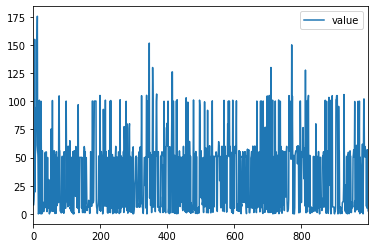

In [67]:
df.plot(y='value')

In [68]:
df[df['metric']=='mttf'].describe()

,value
count,1000.000000
mean,34.830997
std,32.985484
min,0.018800
25%,5.371758
50%,31.015150
75%,55.032575
max,175.500000


So out of 1000 samples, our average time to compromise is ~34 weeks. 